# Workshop Tutorial: MCMC Convergence

In the previous tutorial we ran a sampler several times, either by continuing the previous run or resampling from the latest solution. In this tutorial we will focus on assessing convergence. This will be an inevitably disappointing experience because it turns out that there is no robust way to estimate convergence. Instead, we will inspect the usual diagnostic plots and introduce a new type of plot, autocorrelation function, that will be used to *qualify* (rather than *quantify*) convergence.

**NOTE**: much of the functionality introduced here in this tutorial is new since the 2.3 release and may undergo minor changes before officially being released in the 2.4 release.

Let's start with the usual imports.

In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt

In addition, we will need two more helper functions, erfinv to compute inverse error function, and norm to compute gaussian percentiles:

In [2]:
from scipy.special import erfinv
from scipy.stats import norm

Load the [data from the previous run](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_terra.bundle):

In [3]:
b = phoebe.load('./data/synthetic/after_terra.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10382: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


So far we used three diagnostic plots: log-probability as a function of iteration, corner plot, and trace plot. When there are many walkers, the log-probability and trace plots become cluttered. That is why phoebe provides an alternative way of conveying the same information: *spread* plots.

Say we have $N$ walkers. Each walker has a corresponding log-probability ($\log p$) at each iteration. We can then calculate the mean and standard deviation of all $\log p$ values at each iteration $i$ and plot that as $\langle \log p (i) \rangle \pm \sigma(i)$:

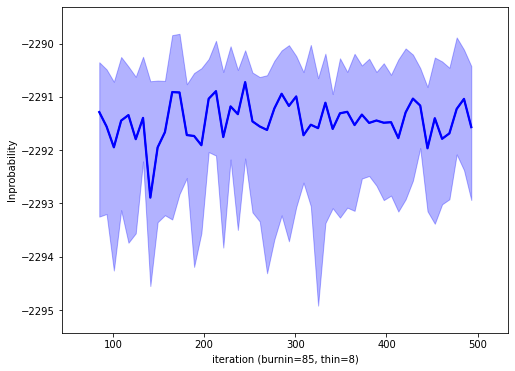

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [4]:
b.plot(solution='round_3', style='lnprobabilities_spread', c='b', show=True)

The blue curve is the mean log-probability and the shaded spread is the $\pm$1-$\sigma$ deviation. Analogously, we can do the same for the trace plot: 

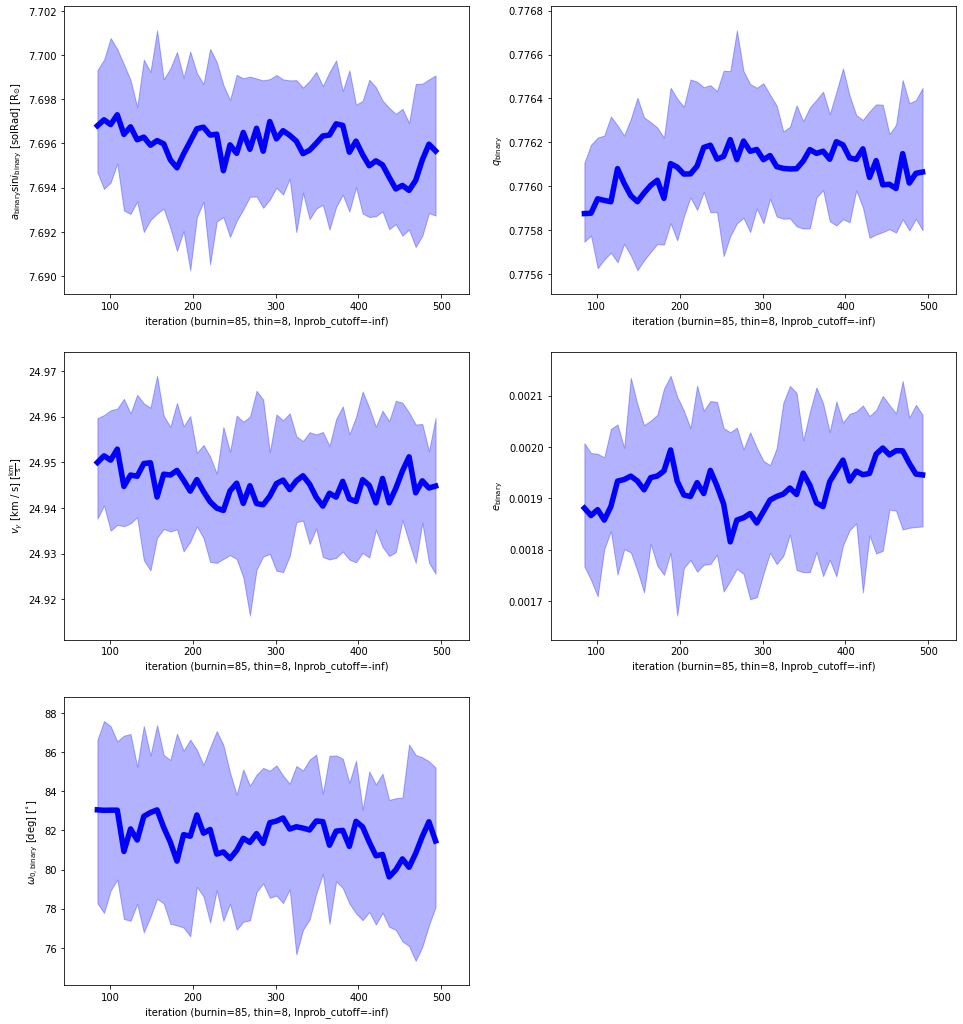

(<autofig.figure.Figure | 5 axes | 10 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [5]:
b.plot(solution='round_3', style='trace_spread', c='b', show=True)

These plots might be helpful in identifying any remaining trends. If there are any trends, chances are that the solution is not fully converged yet. In our case, there seems to be a slight trend in $q$, $v_\gamma$ and $e$. Of course, we strongly discourage this "chi-by-eye" to be the ultimate guidance for any decision-making, but it can prove helpful in spotting problems that might otherwise be elusive. 

Fortunately, we can do better than that. Thoughout the fitting tutorials you've seen that as a "unit of measure" we use autocorrelation times (for example, `burnin` = `burnin_factor` * `max(autocorr_times)`). It's time to shed some light on the whole autocorrelation concept and provide a bit of context on how to interpret that.

The correlation of two (real) functions measures the overlap when one function is "lagged" by some time $\tau$:

$$ (f \star g) (\tau) = \int_{-\infty}^\infty f(t) g(t-\tau) dt. $$

*Auto*correlation is correlation of the function with itself:

$$ (f \star f) (\tau) \equiv (\mathrm{acor}\,f) (\tau) = \int_{-\infty}^\infty f(t) f(t-\tau) dt. $$

For discrete datasets this can be written simply as:

$$ (f \star f)_k \approx \sum_i f_i f_{i-k}. $$

Except in the trivial cases ($f = \mathrm{const}$ or if $f$ is noiseless and perfectly periodic), $(f \star f)_0$ (i.e., the unlagged correlation) will be maximal. Its value depends on the function itself, and is irrelevant for most practical purposes. That's why it is common practice to normalize $\mathrm{acor} \, f$:

$$ \mathrm{acor} \, f_k \mapsto \frac{(f \star f)_k}{(f \star f)_0}. $$

Finally, it is usual to subtract the mean from the function to make it stationary:

$$ f_k \mapsto f_k - \langle f \rangle. $$

While *technically* this is no longer autocorrelation but autocovariance, we will make no distinction between the two. Thus:

$$ (f \star f)_k \approx \frac{\sum_i (f_i-\langle f \rangle) (f_{i-k}-\langle f \rangle)}{\sum_i (f_i-\langle f \rangle)^2}. $$

The first term is the normalization and the second term is the autocorrelation.

Now let's implement this, along with one bell and whistle: [Bartlett's formula](https://en.wikipedia.org/wiki/Correlogram). This will give us an uncertainty estimate for autocorrelation as a function of iteration.

In [6]:
def acf(ts, lags=0, submean=False, normed=True, p=0.05, bartlett=True):
    lags = len(ts) if lags==0 else lags
    c0 = np.sum((ts-ts.mean())**2)/len(ts) if normed else 1.0
    if submean:
        acf = np.array([np.sum((ts[k:]-ts[k:].mean())*(ts[:len(ts)-k]-ts[:len(ts)-k].mean()))/c0/len(ts) for k in range(lags)])
    else:
        acf = np.array([np.sum((ts[k:]-ts.mean())*(ts[:len(ts)-k]-ts.mean()))/c0/len(ts) for k in range(lags)])
    
    if bartlett:
        vacf = np.ones_like(acf)/len(ts)
        vacf[0] = 0
        vacf[1] = 1/len(ts)
        vacf[2:] *= 1+2*np.cumsum(acf[1:-1]**2)
        ci = norm.ppf(1-p/2) * np.sqrt(vacf)
    else:
        ci = np.sqrt(2)*erfinv(1-p)/np.sqrt(len(ts))
    
    return acf, ci

Let's try this in action! Let's take the first walker past the burn-in point:

In [7]:
w1 = b['value@lnprobabilities@round_3'][b['value@burnin@round_3']:,0]

Let's plot it:

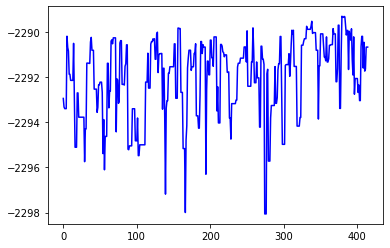

In [8]:
plt.plot(w1, 'b-')

Now we can use this timeseries to calculate the autocorrelation function:

In [9]:
acf_w1, acf_w1_ci = acf(w1, lags=65, normed=True)

Finally, let's plot it and work on interpreting the results:

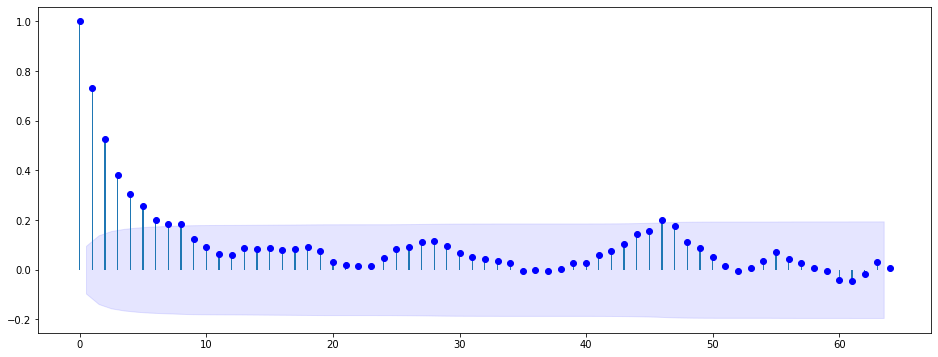

In [10]:
plt.figure(figsize=(16,6))
plt.bar(x=range(len(acf_w1)), height=acf_w1, width=0.1)
plt.plot(range(len(acf_w1)), acf_w1, 'bo')
plt.fill_between(np.arange(1, len(acf_w1_ci))-0.5, -acf_w1_ci[1:], acf_w1_ci[1:], color='b', alpha=0.1)

Whatever points are within the Bartlett boundaries, assuming that the timeseries can be described as a moving average (MA) process, their autocorrelation is not statistically significant. The autocorrelation of those points that lie outside the Bartlett boundaries, on the other hand, is statistically significant. The lag at which the function crosses the Bartlett boundary is the *autocorrelation time*.

In [11]:
acfs = [acf(b['value@lnprobabilities@round_3'][400:,k], lags=100, normed=True) for k in range(16)]

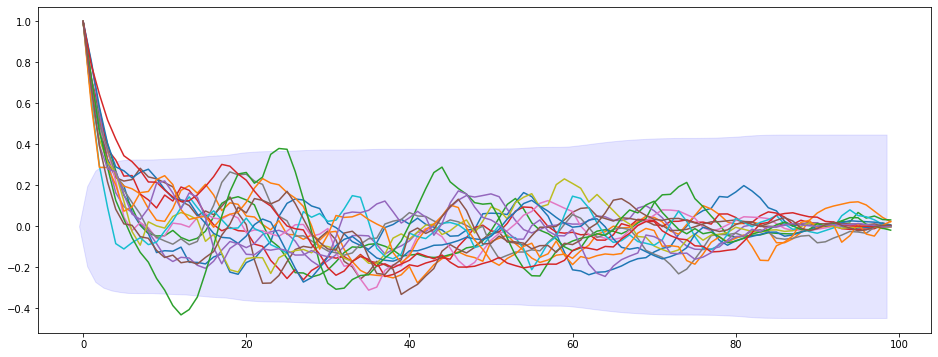

In [12]:
plt.figure(figsize=(16,6))
for k in range(16):
    plt.plot(acfs[k][0], '-')
plt.fill_between(np.arange(len(acfs[0][1]))-0.5, -acfs[0][1], acfs[0][1], color='b', alpha=0.1)
#     plt.axhline(-acfs[k][1], c='g', ls='--')
#     plt.axhline(acfs[k][1], c='g', ls='--')

Now let's try the parameters!

In [13]:
b['value@samples@round_3'].shape

(500, 24, 5)

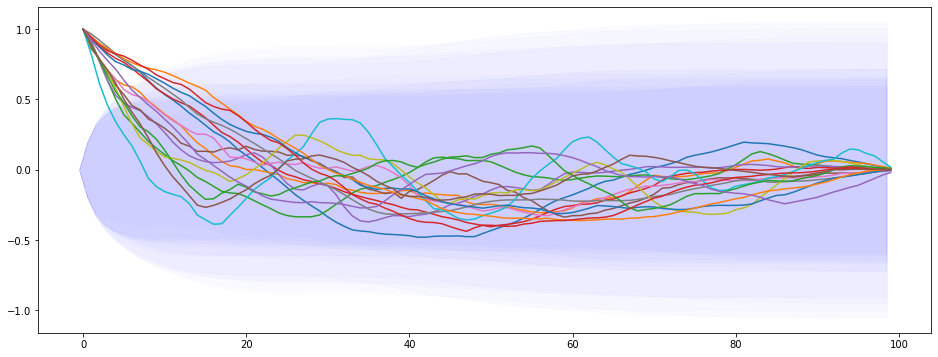

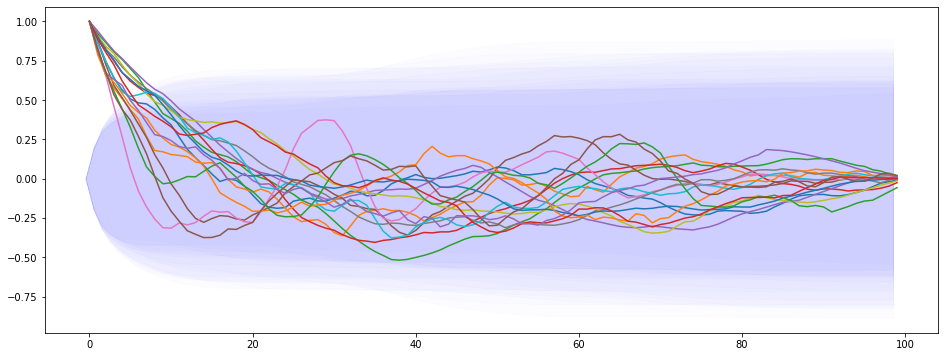

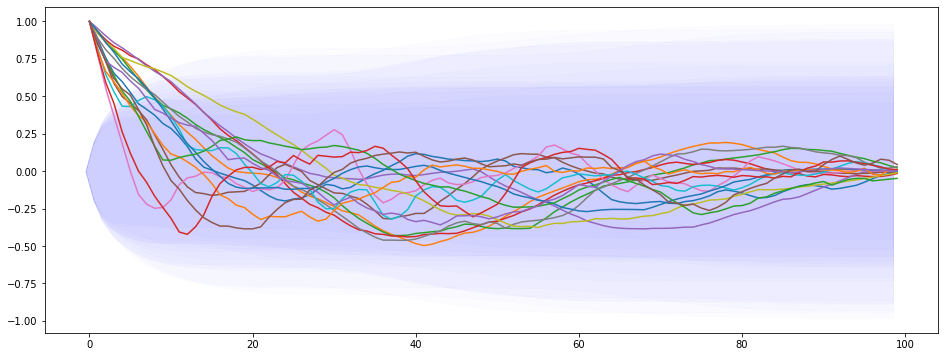

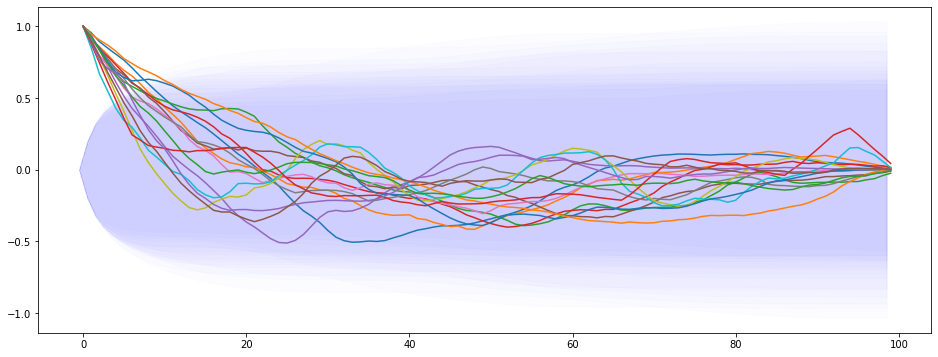

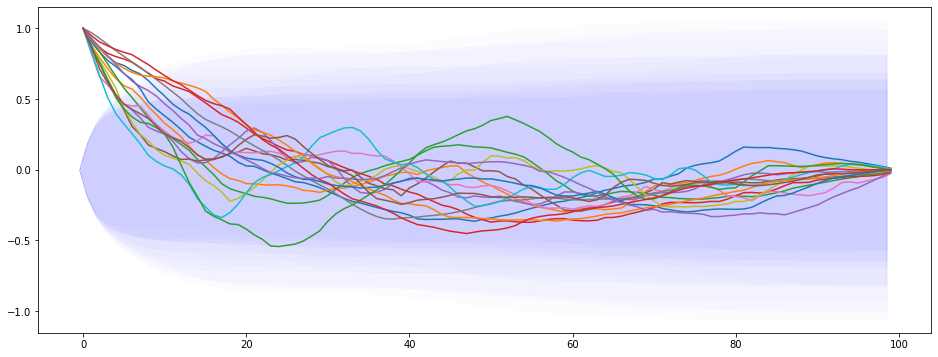

In [14]:
for i in range(5):
    acfs = [acf(b['value@samples@round_3'][400:,k,i], lags=100, normed=True) for k in range(16)]
    plt.figure(figsize=(16,6))
    for k in range(16):
        plt.plot(acfs[k][0], '-')
        plt.fill_between(np.arange(len(acfs[k][1]))-0.5, -acfs[k][1], acfs[k][1], color='b', alpha=0.01)

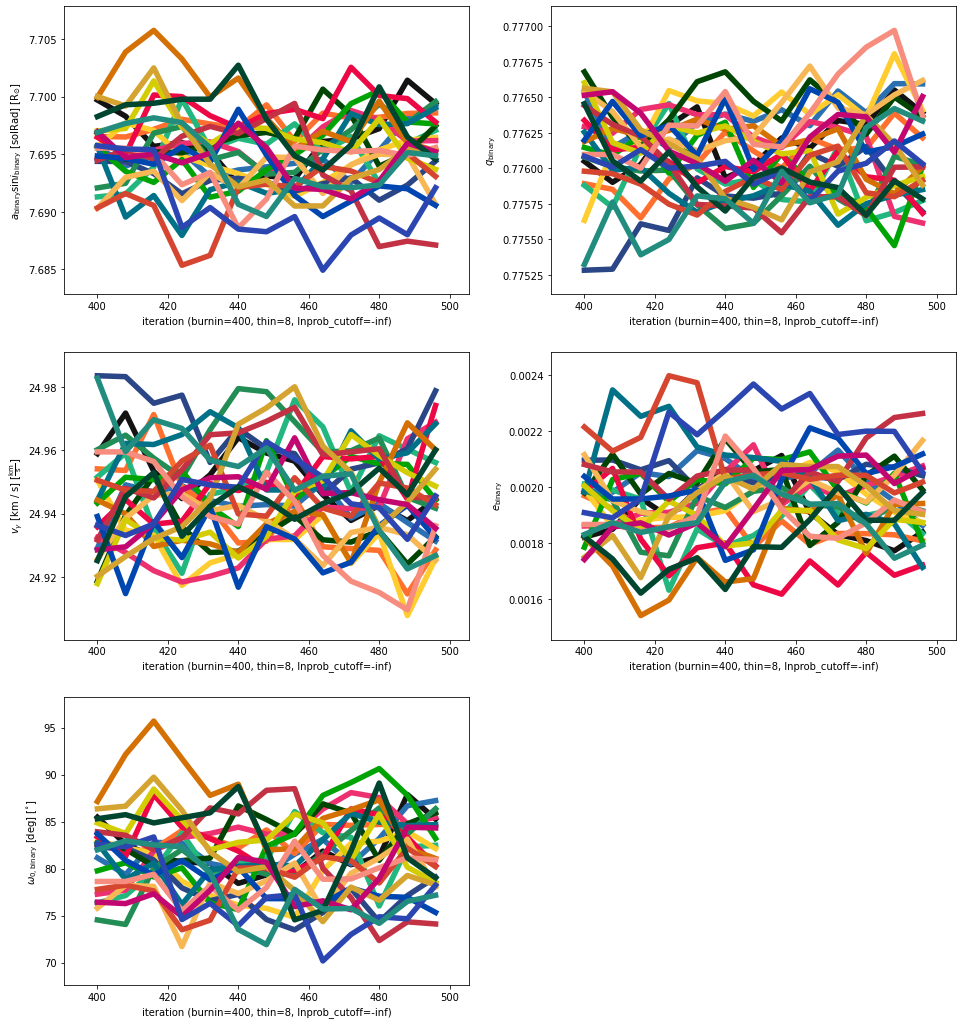

(<autofig.figure.Figure | 5 axes | 120 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [15]:
b.plot(solution='round_3', style='trace', burnin=400, show=True)

While this looks reasonable, it is still dubious whether convergence has been fully reached. Let's do one more run on terra to see whether another 500 iterations will have an impact on the results. For a refresher on deploying a sampling job on an external resource please refer to the [server tutorial](http://phoebe-project.org/workshops/2021june/Tutorial_09_server.ipynb).

In [16]:
b['continue_from@mcmc'] = 'round_3'

In [17]:
# b.run_solver('mcmc', solution='round_4', use_mpi=False, nprocs=24, niters=500)
# b.save('./data/synthetic/after_terra_2.bundle')

We'll skip and load the [pre-computed results](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_terra_2.bundle)

In [18]:
b = phoebe.load('./data/synthetic/after_terra_2.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10382: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


(None, <Figure size 849.6x849.6 with 25 Axes>)

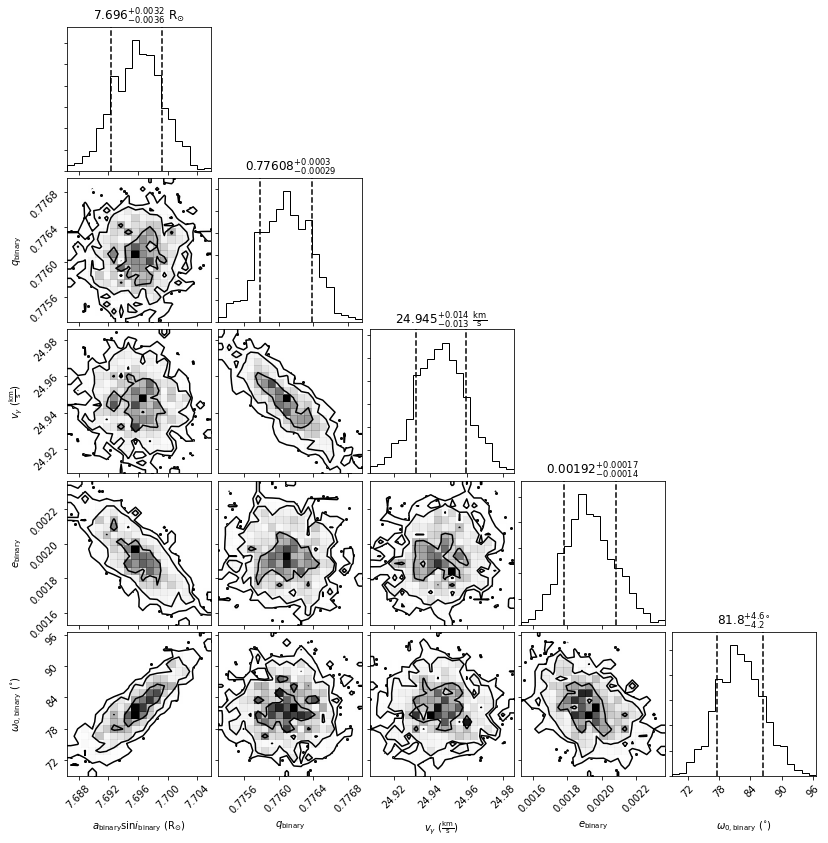

In [19]:
b.plot(solution='round_4', style='corner', burnin=400, show=True)

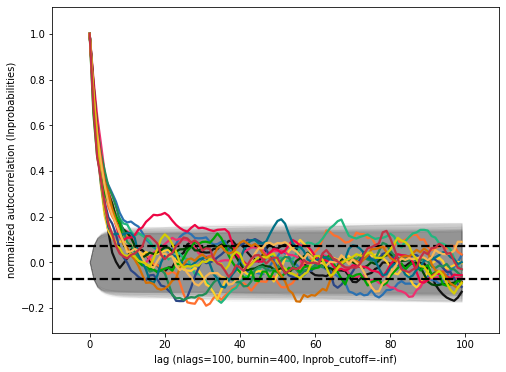

(<autofig.figure.Figure | 1 axes | 34 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [20]:
b.plot(solution='round_4', style='acf_lnprobabilities', nlags=100, burnin=400, show=True)

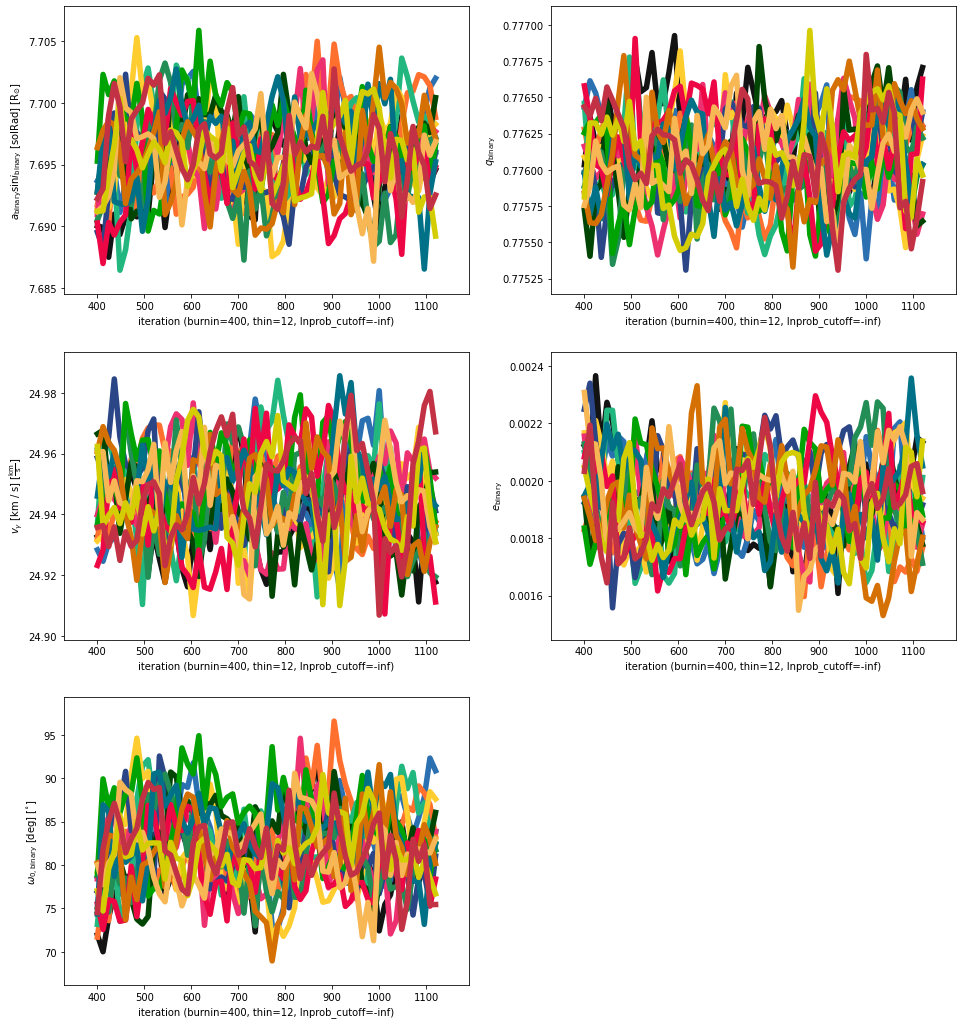

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [21]:
b.plot(solution='round_4', style='trace', burnin=400, show=True)

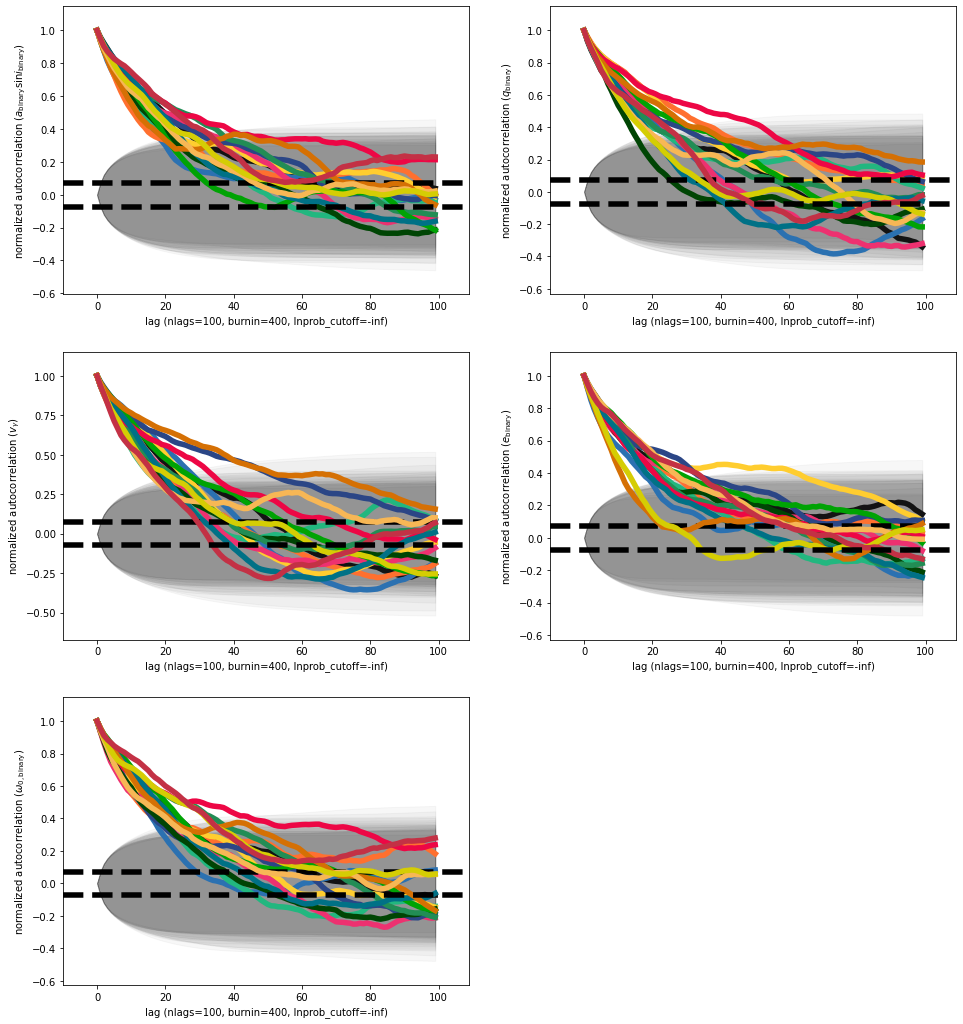

(<autofig.figure.Figure | 5 axes | 170 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [22]:
b.plot(solution='round_4', style='acf', nlags=100, burnin=400, show=True)

This already looks quite good, let's just get the posteriors into a final shape by running another 1500 iterations.

In [23]:
# b['continue_from@mcmc'] = 'round_4'
# b.run_solver('mcmc',
#              solution='final_round',
#              continue_from='round_4',
#              niters=1500,
#              use_server='terra',
#              nprocs=48,
#              walltime=(48,'hr'),
#              overwrite=True)
# b.save('./data/synthetic/after_final_round.bundle')

Again, let's load the [pre-computed results](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_final_round.bundle)

In [24]:
b = phoebe.load('./data/synthetic/after_final_round.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10382: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


# Exercises

**Exercise 1**: Explore all relevant tracers for this final round. Plot log-probability plot, corner plot, and the autocorrelation function for log-probability and parameters. What can you say about convergence?